# read data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plot features by missing proportion

<Figure size 360x2160 with 0 Axes>

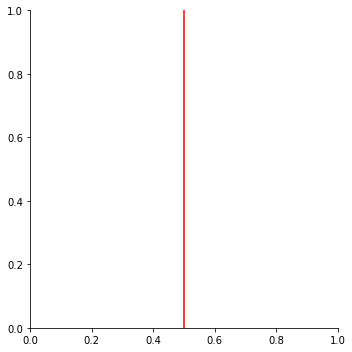

In [12]:
plt.figure(figsize=(5,30))
sns.displot(
    data=qtw.iloc[:,120:].isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1
)
plt.axvline(0.5, color = "r")
# plt.savefig("missing_percentages_120_remaining.png", dpi=100)

# missing values over years

In [98]:
missing_values_over_yrs = qtw.drop('Year', axis = 1).isna().groupby(qtw.Year, sort=False).sum().reset_index() / len(qtw) * 100 > (100/12)

In [77]:
missing_values_over_yrs.to_excel("missing_values_over_yrs.xlsx")

In [22]:
# drop cols with > .5 missing values in one of the years
qtw = qtw.drop(['Age', 
                'Marital',
                'Income_5Gp',
                'Base_QRMethod_1',
                'Base_QRMethod_10',
                'Base_QRMethod_11',
                'Base_QRMethod_12',
                'Base_QRMethod_13',
                'M1_QReason_6',
                'M1_QReason_13',
                'ID',
                'Serial_Num',
                'Unnamed: 0'], axis=1)

KeyError: "['Age' 'Marital' 'Income_5Gp' 'Base_QRMethod_1' 'Base_QRMethod_10'\n 'Base_QRMethod_11' 'Base_QRMethod_12' 'Base_QRMethod_13' 'M1_QReason_6'\n 'M1_QReason_13' 'ID' 'Serial_Num' 'Unnamed: 0'] not found in axis"

# one-hot encoded qtw dataframe

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
qtw = pd.read_csv("QTW14-19.csv")
# drop cols with > .5 missing values
qtw = qtw.drop(['Children', 
                'Children_coliving',
                'Income_since18',
                'Base_QRMethod_5',
                'Base_QRMethod_14',
                'Base_QRMethod_15',
                'Base_QRMethod_16',
                'M1_QA_acc',
                'M1_QReason_3',
                'M1_QReason_8'], axis=1)
# drop traj cols
qtw = qtw[qtw.columns.drop(list(qtw.filter(regex='Traj')))]
qtw = qtw[qtw.columns.drop(list(qtw.filter(regex='traj')))]
# drop cols with > .5 missing values in one of the years
qtw = qtw.drop(['Age', 
                'Marital',
                'Income_5Gp',
                'Base_QRMethod_1',
                'Base_QRMethod_10',
                'Base_QRMethod_11',
                'Base_QRMethod_12',
                'Base_QRMethod_13',
                'M1_QReason_6',
                'M1_QReason_13',
                'ID',
                'Serial_Num',
                'Unnamed: 0'], axis=1)
# remove ITT columns except M6_VQ_ITT
m6_vq_itt = qtw["M6_VQ_ITT"]
qtw = qtw[qtw.columns.drop(list(qtw.filter(regex='M6_')))]
qtw = qtw[qtw.columns.drop(list(qtw.filter(regex='_ITT')))]
qtw["M6_VQ_ITT"] = m6_vq_itt

/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,12,15,42,43,44,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

df = qtw

mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df


#Imputation
qtw = imputation(qtw,qtw.select_dtypes(include = "object").columns.values.tolist())

# VIF for cont. variables

In [4]:
cont_colnames = qtw.select_dtypes(exclude = "object").columns.values.tolist()
qtw_cont = qtw[cont_colnames]

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = qtw_cont.columns
vif_data["VIF"] = [variance_inflation_factor(qtw_cont.values, i)
                          for i in range(len(qtw_cont.columns))]

/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [6]:
vif_data.to_excel("vif.xlsx")

In [7]:
drop_names = vif_data[vif_data["VIF"] >= 10]["feature"].tolist()
qtw = qtw[qtw.columns.drop(drop_names)]

In [8]:
drop_names

['Base_QImportance',
 'Base_QDifficulty',
 'M3_QImportance',
 'M3_QDifficulty',
 'M3_QConfidence']

# Cat. feature selection
By chi-sq. test, p-value < .05

In [9]:
cat_colnames = qtw.select_dtypes(include = "object").columns.values.tolist()
qtw_cat = qtw[cat_colnames]

In [10]:
# Import the function
from scipy.stats import chi2_contingency
#Testing the relationship

chi2_check = []
categorical_columns = qtw_cat.columns.values.tolist()
for i in categorical_columns:
    if chi2_contingency(pd.crosstab(qtw_cat['M6_VQ_ITT'], qtw_cat[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [categorical_columns, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']

In [11]:
print(res[res['Hypothesis'] == "Fail to Reject Null Hypothesis"]['Column'].tolist())

['Sex', 'Base_QRMethod_2', 'Base_QRMethod_3', 'Base_QRMethod_4', 'Base_QRMethod_6', 'Base_QRMethod_7', 'Base_QRMethod_8']


In [12]:
res.to_excel("cat_variables.xlsx")

In [13]:
drop_names = res[res['Hypothesis'] == "Fail to Reject Null Hypothesis"]['Column'].tolist()
qtw = qtw[qtw.columns.drop(drop_names)]

# LASSO

In [14]:
qtw_encoded = pd.get_dummies(qtw, drop_first = True)

In [15]:
from sklearn.linear_model import LogisticRegression
X = qtw_encoded[qtw_encoded.columns.drop(list(qtw_encoded.filter(regex='M6_VQ_ITT')))]
y = qtw_encoded["M6_VQ_ITT_Smoking"]
y = 1 - y
y.rename("M6_VQ_ITT_Abstinence")

0       1
1       0
2       0
3       0
4       0
       ..
6583    0
6584    0
6585    1
6586    0
6587    0
Name: M6_VQ_ITT_Abstinence, Length: 6588, dtype: uint8

In [16]:
log_reg = LogisticRegression(penalty='l1', solver='liblinear').fit(X, y)

In [17]:
lasso_df = pd.DataFrame({"Features": X.columns.values.tolist(),
                    "Coef": log_reg.coef_[0].tolist()})

In [18]:
lasso_df.to_excel("lasso.xlsx")
lasso_df[lasso_df["Coef"] == 0].to_excel("lasso_dump.xlsx")
lasso_df[lasso_df["Coef"] != 0].to_excel("lasso_subset.xlsx")

In [19]:
print(lasso_df[lasso_df["Coef"] == 0]["Features"].tolist())

['M0_R_P_c', 'Group_2015-AR', 'Group_2015-Leaflet', 'Group_2016-HAR', 'Group_2017-IM', 'Group_2019-B', 'District_living_Kowloon City', 'District_living_Kwai Tsing', 'District_living_Mainland', 'District_living_Shatin', 'District_living_Tsuen Wan', 'District_living_Wong Tai Sin', 'District_living_Yuen Long', 'Employment_Unemployed', 'Base_CpdGp_31+', 'Base_QA_time_within 6 months (but before the passing month)', 'Base_QA_time_within this year (but before the passing 6 months)', 'Base_Ready_In 60 days', 'Base_QRMethod_9_Use', 'M1_QA_Num_No quit attempt after joining QTW', 'M1_QA_Num_Twice', 'M1_QReason_4_No quit attempt after joining QTW', 'M1_QReason_5_Yes', 'M1_QReason_11_No quit attempt after joining QTW', 'M1_Withdrawal_1_Yes', 'M1_Withdrawal_2_No quit attempt after joining QTW', 'M1_Withdrawal_4_No quit attempt after joining QTW', 'M1_Withdrawal_4_Yes', 'M1_Withdrawal_5_No quit attempt after joining QTW', 'M1_Withdrawal_6_No quit attempt after joining QTW', 'M1_Withdrawal_7_Yes']


In [20]:
drop_names = [
    "M0_R_P_c",
    "M1_R_P_c",
    "M2_R_P_c",
    "M3_R_P_c",
    "Group",
    "District_living",
    "Edu",
    "Base_Time_1st_cig",
    "Base_QA",
    "Base_QRMethod_9",
    "M1_QA",
    "M1_QReason_2",
    "M1_QReason_5",
    "M1_QReason_7",
    "M1_QReason_10",
    "M1_QReason_11",
    "M1_Withdrawal_1",
    "M1_Withdrawal_2",
    "M1_Withdrawal_4",
    "M1_Withdrawal_6",
    "M1_Withdrawal_7",
    "M1_Withdrawal_9",
    "M3_QA_acc"
]
qtw = qtw[qtw.columns.drop(drop_names)]

# save variables to pickle

In [21]:
select_columns = qtw.columns.values.tolist()
qtw_orig = pd.read_csv("QTW14-19.csv")

qtw_subset = qtw_orig[select_columns]

qtw_subset = qtw_subset[qtw_subset.columns.drop(list(qtw.filter(regex='M6_')))]
qtw_subset["M6_VQ_ITT"] = qtw_orig["M6_VQ_ITT"]

/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,12,15,42,43,44,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
qtw_subset.columns.values

array(['Year', 'Age_5Gp', 'Housing', 'Employment', 'Base_CO', 'Base_HSI',
       'Base_CpdGp', 'Base_Cpd', 'Base_Age_weekly_smoking',
       'Base_QA_time', 'Base_Ready', 'Base_QConfidence', 'M1_Q', 'M1_Cpd',
       'M1_QA_Num', 'M1_R50', 'M1_QReason_1', 'M1_QReason_4',
       'M1_QReason_9', 'M1_QReason_12', 'M1_Withdrawal_3',
       'M1_Withdrawal_5', 'M1_Withdrawal_8', 'M1_Withdrawal_10', 'M2_Q',
       'M2_Cpd', 'M2_QA', 'M2_QA_acc', 'M2_R50', 'M3_Q', 'M3_Cpd',
       'M3_QA', 'M3_R50', 'Arm', 'Treatment', 'M6_VQ_ITT'], dtype=object)

In [23]:
# save variables to pickle
import pickle
filename = "variables.pickle"
with open(filename, 'wb') as f:
    pickle.dump({
        'qtw': qtw_subset
    }, f)

# get variables from pickle

In [25]:
import pickle
import pandas as pd

with open('variables.pickle', 'rb') as f:
    pic = pickle.load(f)
# qtw_imputed = pic['qtw_imputed']
qtw_encoded = pic['qtw_encoded']